# Task 3

Let's implement a Neural Network, which contains a stack of 2 LSTMs, both processing sequences, 2 Fully Connected layers and 1-3 Dropouts. You can use max. one additional convolutional layer, if needed. Let's use Sequential API, Adam optimizer and MNIST dataset. Use properly the train, val and test splits presented below. Your model should obtain at least 98.5% accuracy on both val and test sets. Then, let's implement the Grad-CAM algorithm to visualize a class activation heatmap (function get_gradcam_heatmap).

In [1]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

In [2]:
import tensorflow as tf

x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
x_val = tf.cast(x_val, tf.float32)

In [3]:
from keras.utils.np_utils import to_categorical   

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [4]:
import numpy as np

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [5]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense, Flatten, Conv2D, Reshape
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape = (28,28,1)))
model.add(Conv2D(16, (4,4), padding='same', activation='relu'))
model.add(Reshape((28,448)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(196))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])

In [8]:
model.fit(x_train, y_train, batch_size=256, epochs=8, validation_data=(x_val, y_val))

Epoch 1/8
196/196 [==============================] - 9s 22ms/step - loss: 0.8649 - acc: 0.7101 - val_loss: 0.1641 - val_acc: 0.9530
Epoch 2/8
196/196 [==============================] - 3s 17ms/step - loss: 0.1575 - acc: 0.9536 - val_loss: 0.0910 - val_acc: 0.9736
Epoch 3/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0942 - acc: 0.9736 - val_loss: 0.0714 - val_acc: 0.9789
Epoch 4/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0830 - acc: 0.9753 - val_loss: 0.0605 - val_acc: 0.9820
Epoch 5/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0606 - acc: 0.9821 - val_loss: 0.0666 - val_acc: 0.9824
Epoch 6/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0483 - acc: 0.9854 - val_loss: 0.0474 - val_acc: 0.9864
Epoch 7/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0446 - acc: 0.9872 - val_loss: 0.0598 - val_acc: 0.9855
Epoch 8/8
196/196 [==============================] - 3s 17ms/step - loss: 0.

In [9]:
model.optimizer.learning_rate = 1e-5

In [10]:
model.fit(x_train, y_train, batch_size=256, epochs=8, validation_data=(x_val, y_val))

Epoch 1/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0254 - acc: 0.9926 - val_loss: 0.0436 - val_acc: 0.9884
Epoch 2/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0217 - acc: 0.9938 - val_loss: 0.0421 - val_acc: 0.9884
Epoch 3/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0191 - acc: 0.9950 - val_loss: 0.0413 - val_acc: 0.9885
Epoch 4/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0177 - acc: 0.9952 - val_loss: 0.0407 - val_acc: 0.9891
Epoch 5/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0167 - acc: 0.9955 - val_loss: 0.0404 - val_acc: 0.9893
Epoch 6/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0152 - acc: 0.9960 - val_loss: 0.0402 - val_acc: 0.9895
Epoch 7/8
196/196 [==============================] - 3s 17ms/step - loss: 0.0147 - acc: 0.9960 - val_loss: 0.0401 - val_acc: 0.9896
Epoch 8/8
196/196 [==============================] - 3s 16ms/step - loss: 0.

In [11]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0390 - acc: 0.9898


[0.03899970278143883, 0.989799976348877]

In [12]:
def get_gradcam_heatmap( model, img ):
  from tensorflow.keras.models import Model
  #sectioning model

  #model with the last convolutional network
  conv_model = Model(model.inputs, model.layers[0].output)

  #model with task-specific network (the rest of the layers)
  ts_input = Input(shape=model.layers[0].output.shape[1:])
  x = ts_input
  for layer in model.layers[1:]:
    x = layer(x)
  ts_model = Model(ts_input, x)

  with tf.GradientTape() as g:
    conv_out = conv_model(np.expand_dims(img, axis=0))
    g.watch(conv_out)
    preds = ts_model(conv_out)
    pred_channel = preds[:, tf.argmax(preds[0])]

  grads = g.gradient(target=pred_channel, sources=conv_out)[0]

  grads = (np.asarray(grads).sum(axis=(0,1)))/(28*28)
  conv_out = np.asarray(conv_out).copy().sum(axis=0)

  for i in range(grads.shape[-1]):
    conv_out[:,:,i] *= grads[i]

  heatmap = tf.keras.activations.relu(conv_out.sum(axis=2))

  return heatmap

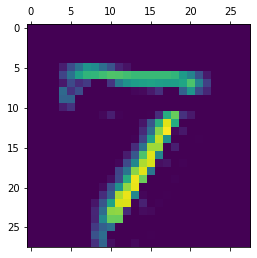

In [13]:
import matplotlib.pyplot as plt
heatmap = get_gradcam_heatmap( model, x_test[0])
plt.matshow(heatmap)
plt.show()

## Save the trained model

In [14]:
model.save('Weronika_Skibicka_410952', save_format='h5')

## Submission
You need to send by the deadline:
- the trained model with architecture and weights (as YourFirstName_YourSourname_Indeks.h5 file).
- and jupyter notebook (ipynb file) with all outputs and training logs (as YourFirstName_YourSourname_Indeks.ipynb file). The trained model should be reproducible by running Runtime -> Run all.